In [256]:
from gensim import models
from gensim import similarities
from gensim import corpora
import gensim
from six import iteritems
import gensim
import numpy as np
import scipy.sparse
import logging
import os
import matplotlib.pyplot as plt
import random
import scipy as sp
import nltk
import jieba #中文分词
import time
import numpy.linalg as LA
import queue
import csv
import re
from collections import defaultdict
from sklearn.decomposition import PCA
from pprint import pprint
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Create Dictionary

In [257]:
punctuation = '，：/？“”【】 ！。.\\*（）()’‘·、!,;:?"\''
def remove_punctuation(text):
    text = re.sub(r'[{}]+'.format(punctuation),'',text)
    return text

## Hyperparameters

In [310]:
NEWS_PATH = '/Users/tony/Desktop/OfflineClustering/RawData/datap_news_html.csv'
TEST_DATA_PATH = '/Users/tony/Desktop/OfflineClustering/RawData/clustering_test_data.txt'

In [315]:
test_texts = []
with open(TEST_DATA_PATH) as test_file:
    test_reader = csv.reader(test_file, delimiter = ' ')
    for row in test_reader:
        row = remove_punctuation(row[0])
        str1 = ' '.join(jieba.cut(row))
        textarr = str1.split()
        test_texts.append(textarr)

In [316]:
print(test_texts)

[['中', '美', '贸易战'], ['中', '美', '贸易战', '初现', '端倪'], ['中', '美', '局部', '贸易战', '不可避免'], ['中', '美', '贸易战', '一夜', '回到', '解放前'], ['张明', '讲座', '中', '美', '贸易战', '步向', '何方'], ['中', '美', '贸易战', '重燃', '战火'], ['中', '美', '贸易战', '疑云', '再起'], ['中', '美', '贸易战', '冲击波', '全球股市', '风声鹤唳'], ['江南', '愤青', '谈谈', '中', '美', '贸易战'], ['中', '美', '贸易战', '第一枪', '子弹', '还要', '再飞', '一会儿'], ['中', '美', '贸易战', '波澜', '再起', '众多', '化工产品', '卷入', '其中'], ['中', '美', '贸易战', '损失', '程度', '比较'], ['保监会', '发布', '险企', '股权', '管理', '修订版', '新规', '单一', '股东', '持股', '不得', '超过', '13'], ['保监会', '修订', '发布', '险企', '股权', '管理', '办法', '严格', '股东', '准入'], ['险企', '股权', '新规', '发布', '单一', '股东', '持股', '比', '上限', '由', '51', '％', '降为', '13'], ['险企', '股权', '管理', '新规', '单一', '股东', '持股', '上限', '由', '51%', '降为', '13'], ['险企', '股权', '管理', '新规', '单一', '股东', '持股', '比例', '上限', '降至', '13'], ['银监会', '发布', '商业银行', '股权', '管理', '征求意见', '稿'], ['银监会', '发布', '商业银行', '股权', '管理', '配套', '文件'], ['险企', '股权', '管理', '办法', '昨日', '正式', '落地', '单一', '股东', '持股', '不得', '超过', '13'], ['商业

In [268]:
#####final line_count = 670140       
text_set = set()
id2text = {}
with open(NEWS_PATH) as file:
    reader = csv.reader(file, delimiter = ',')
    for row in reader:
        if len(row) < 3:
            continue
        temp = remove_punctuation(row[2])
        text_set.add(temp)
id = 0
texts = []
for text in text_set:
    str1 = ' '.join(jieba.cut(text))
    textarr = str1.split()
    id2text[id] = text
    texts.append(textarr)
    id += 1

In [267]:
print(texts[1231])
print(id2text[1232])

['中纪委', '驻', '保监会', '纪检组', '长', '重点', '查处', '选用', '人', '等', '领域', '腐败']
中纪委驻保监会纪检组长重点查处选用人等领域腐败


In [261]:
def default():
    return 0

def defualtdict_emptylist():
    return []

In [264]:
print(len(texts))
print(texts[:10])

982691
[['火山石', '资本', '章苏阳', '将来', '社会', '会', '很', '无聊', '没有', '秘密', '可保'], ['高尚', '全', '中国', '经济', '处于', '很', '正常', '很', '合理', '的', '区间'], ['黑龙江', '短缺', '药品', '保障', '供应', '新机制', '建立', '保障', '临床', '供应'], ['朸', '濬', '国际', '01355', '闵志东', '辞任', '执行', '董事'], ['协同', '创新', '引领', '集成电路', '产业', '升级', '大单', '抢筹', '3', '只', '概念股'], ['绍兴', '银行', '办理', '票据', '现', '四项', '违法', '违规', '遭罚', '3650', '万元'], ['创板', '股', '散水', 'ITP', '续', '遭洗', '仓急', '跌', '逾', '四成'], ['母婴', '之', '家', '连续', '四年', '亏损', '持续', '经营', '能力', '存疑'], ['奋斗', '是', '通往', '幸福', '的', '入口'], ['重庆', '全市', '公立医院', '薪酬', '制度', '改革', '全', '覆盖']]


## Filter Out Words with Low Frequencies

In [269]:
def filter_once_words(texts):
    """
    Function filter out words that occur only once throught the corpus in order to boost the performance
    Input --- The str of the file path
    Output --- List of Lists, each sublist corresponds to a list of Chinese tokens, e.g: ["我们","都是","中国人"]
    """
    freqdict = defaultdict(default)
    for text in texts:
        for token in text:
            freqdict[token] += 1
    word_once = set()
    for key in freqdict.keys():
        if freqdict[key] == 1:
            word_once.add(key)
    texts = [
    [token for token in text if token not in word_once]
    for text in texts
    ]
    return texts

In [270]:
texts = filter_once_words(texts)

In [271]:
dictionary = corpora.Dictionary(texts)
dictionary.save('news_without_once_word.dict')

2019-06-06 10:09:55,592 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-06-06 10:09:55,737 : INFO : adding document #10000 to Dictionary(21288 unique tokens: ['会', '可保', '将来', '很', '无聊']...)
2019-06-06 10:09:55,872 : INFO : adding document #20000 to Dictionary(31392 unique tokens: ['会', '可保', '将来', '很', '无聊']...)
2019-06-06 10:09:56,004 : INFO : adding document #30000 to Dictionary(39006 unique tokens: ['会', '可保', '将来', '很', '无聊']...)
2019-06-06 10:09:56,140 : INFO : adding document #40000 to Dictionary(45232 unique tokens: ['会', '可保', '将来', '很', '无聊']...)
2019-06-06 10:09:56,278 : INFO : adding document #50000 to Dictionary(50543 unique tokens: ['会', '可保', '将来', '很', '无聊']...)
2019-06-06 10:09:56,727 : INFO : adding document #60000 to Dictionary(55243 unique tokens: ['会', '可保', '将来', '很', '无聊']...)
2019-06-06 10:09:56,912 : INFO : adding document #70000 to Dictionary(59469 unique tokens: ['会', '可保', '将来', '很', '无聊']...)
2019-06-06 10:09:57,097 : INFO : adding docum

2019-06-06 10:10:06,825 : INFO : adding document #660000 to Dictionary(132365 unique tokens: ['会', '可保', '将来', '很', '无聊']...)
2019-06-06 10:10:06,976 : INFO : adding document #670000 to Dictionary(132707 unique tokens: ['会', '可保', '将来', '很', '无聊']...)
2019-06-06 10:10:07,155 : INFO : adding document #680000 to Dictionary(133022 unique tokens: ['会', '可保', '将来', '很', '无聊']...)
2019-06-06 10:10:07,327 : INFO : adding document #690000 to Dictionary(133347 unique tokens: ['会', '可保', '将来', '很', '无聊']...)
2019-06-06 10:10:07,476 : INFO : adding document #700000 to Dictionary(133636 unique tokens: ['会', '可保', '将来', '很', '无聊']...)
2019-06-06 10:10:07,677 : INFO : adding document #710000 to Dictionary(133911 unique tokens: ['会', '可保', '将来', '很', '无聊']...)
2019-06-06 10:10:07,876 : INFO : adding document #720000 to Dictionary(134145 unique tokens: ['会', '可保', '将来', '很', '无聊']...)
2019-06-06 10:10:08,064 : INFO : adding document #730000 to Dictionary(134388 unique tokens: ['会', '可保', '将来', '很', '无

# Creating Corpus

In [272]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('news_without_once_word.mm', corpus)

2019-06-06 10:10:26,614 : INFO : storing corpus in Matrix Market format to news_without_once_word.mm
2019-06-06 10:10:26,618 : WARNING : this function is deprecated, use smart_open.open instead
2019-06-06 10:10:26,621 : INFO : saving sparse matrix to news_without_once_word.mm
2019-06-06 10:10:26,621 : INFO : PROGRESS: saving document #0
2019-06-06 10:10:26,651 : INFO : PROGRESS: saving document #1000
2019-06-06 10:10:26,690 : INFO : PROGRESS: saving document #2000
2019-06-06 10:10:26,716 : INFO : PROGRESS: saving document #3000
2019-06-06 10:10:26,746 : INFO : PROGRESS: saving document #4000
2019-06-06 10:10:26,769 : INFO : PROGRESS: saving document #5000
2019-06-06 10:10:26,793 : INFO : PROGRESS: saving document #6000
2019-06-06 10:10:26,820 : INFO : PROGRESS: saving document #7000
2019-06-06 10:10:26,837 : INFO : PROGRESS: saving document #8000
2019-06-06 10:10:26,857 : INFO : PROGRESS: saving document #9000
2019-06-06 10:10:26,885 : INFO : PROGRESS: saving document #10000
2019-06-06

2019-06-06 10:10:29,309 : INFO : PROGRESS: saving document #120000
2019-06-06 10:10:29,335 : INFO : PROGRESS: saving document #121000
2019-06-06 10:10:29,354 : INFO : PROGRESS: saving document #122000
2019-06-06 10:10:29,372 : INFO : PROGRESS: saving document #123000
2019-06-06 10:10:29,389 : INFO : PROGRESS: saving document #124000
2019-06-06 10:10:29,406 : INFO : PROGRESS: saving document #125000
2019-06-06 10:10:29,427 : INFO : PROGRESS: saving document #126000
2019-06-06 10:10:29,445 : INFO : PROGRESS: saving document #127000
2019-06-06 10:10:29,463 : INFO : PROGRESS: saving document #128000
2019-06-06 10:10:29,481 : INFO : PROGRESS: saving document #129000
2019-06-06 10:10:29,499 : INFO : PROGRESS: saving document #130000
2019-06-06 10:10:29,517 : INFO : PROGRESS: saving document #131000
2019-06-06 10:10:29,536 : INFO : PROGRESS: saving document #132000
2019-06-06 10:10:29,561 : INFO : PROGRESS: saving document #133000
2019-06-06 10:10:29,584 : INFO : PROGRESS: saving document #13

2019-06-06 10:10:31,826 : INFO : PROGRESS: saving document #243000
2019-06-06 10:10:31,844 : INFO : PROGRESS: saving document #244000
2019-06-06 10:10:31,863 : INFO : PROGRESS: saving document #245000
2019-06-06 10:10:31,883 : INFO : PROGRESS: saving document #246000
2019-06-06 10:10:31,900 : INFO : PROGRESS: saving document #247000
2019-06-06 10:10:31,920 : INFO : PROGRESS: saving document #248000
2019-06-06 10:10:31,939 : INFO : PROGRESS: saving document #249000
2019-06-06 10:10:31,961 : INFO : PROGRESS: saving document #250000
2019-06-06 10:10:31,980 : INFO : PROGRESS: saving document #251000
2019-06-06 10:10:31,999 : INFO : PROGRESS: saving document #252000
2019-06-06 10:10:32,021 : INFO : PROGRESS: saving document #253000
2019-06-06 10:10:32,041 : INFO : PROGRESS: saving document #254000
2019-06-06 10:10:32,061 : INFO : PROGRESS: saving document #255000
2019-06-06 10:10:32,080 : INFO : PROGRESS: saving document #256000
2019-06-06 10:10:32,098 : INFO : PROGRESS: saving document #25

2019-06-06 10:10:34,247 : INFO : PROGRESS: saving document #366000
2019-06-06 10:10:34,266 : INFO : PROGRESS: saving document #367000
2019-06-06 10:10:34,286 : INFO : PROGRESS: saving document #368000
2019-06-06 10:10:34,304 : INFO : PROGRESS: saving document #369000
2019-06-06 10:10:34,327 : INFO : PROGRESS: saving document #370000
2019-06-06 10:10:34,348 : INFO : PROGRESS: saving document #371000
2019-06-06 10:10:34,366 : INFO : PROGRESS: saving document #372000
2019-06-06 10:10:34,386 : INFO : PROGRESS: saving document #373000
2019-06-06 10:10:34,403 : INFO : PROGRESS: saving document #374000
2019-06-06 10:10:34,422 : INFO : PROGRESS: saving document #375000
2019-06-06 10:10:34,442 : INFO : PROGRESS: saving document #376000
2019-06-06 10:10:34,461 : INFO : PROGRESS: saving document #377000
2019-06-06 10:10:34,480 : INFO : PROGRESS: saving document #378000
2019-06-06 10:10:34,499 : INFO : PROGRESS: saving document #379000
2019-06-06 10:10:34,518 : INFO : PROGRESS: saving document #38

2019-06-06 10:10:36,881 : INFO : PROGRESS: saving document #489000
2019-06-06 10:10:36,902 : INFO : PROGRESS: saving document #490000
2019-06-06 10:10:36,924 : INFO : PROGRESS: saving document #491000
2019-06-06 10:10:36,946 : INFO : PROGRESS: saving document #492000
2019-06-06 10:10:36,966 : INFO : PROGRESS: saving document #493000
2019-06-06 10:10:36,988 : INFO : PROGRESS: saving document #494000
2019-06-06 10:10:37,009 : INFO : PROGRESS: saving document #495000
2019-06-06 10:10:37,028 : INFO : PROGRESS: saving document #496000
2019-06-06 10:10:37,047 : INFO : PROGRESS: saving document #497000
2019-06-06 10:10:37,067 : INFO : PROGRESS: saving document #498000
2019-06-06 10:10:37,086 : INFO : PROGRESS: saving document #499000
2019-06-06 10:10:37,105 : INFO : PROGRESS: saving document #500000
2019-06-06 10:10:37,125 : INFO : PROGRESS: saving document #501000
2019-06-06 10:10:37,144 : INFO : PROGRESS: saving document #502000
2019-06-06 10:10:37,163 : INFO : PROGRESS: saving document #50

2019-06-06 10:10:39,396 : INFO : PROGRESS: saving document #612000
2019-06-06 10:10:39,417 : INFO : PROGRESS: saving document #613000
2019-06-06 10:10:39,436 : INFO : PROGRESS: saving document #614000
2019-06-06 10:10:39,456 : INFO : PROGRESS: saving document #615000
2019-06-06 10:10:39,476 : INFO : PROGRESS: saving document #616000
2019-06-06 10:10:39,497 : INFO : PROGRESS: saving document #617000
2019-06-06 10:10:39,517 : INFO : PROGRESS: saving document #618000
2019-06-06 10:10:39,542 : INFO : PROGRESS: saving document #619000
2019-06-06 10:10:39,565 : INFO : PROGRESS: saving document #620000
2019-06-06 10:10:39,588 : INFO : PROGRESS: saving document #621000
2019-06-06 10:10:39,610 : INFO : PROGRESS: saving document #622000
2019-06-06 10:10:39,632 : INFO : PROGRESS: saving document #623000
2019-06-06 10:10:39,652 : INFO : PROGRESS: saving document #624000
2019-06-06 10:10:39,672 : INFO : PROGRESS: saving document #625000
2019-06-06 10:10:39,690 : INFO : PROGRESS: saving document #62

2019-06-06 10:10:42,150 : INFO : PROGRESS: saving document #735000
2019-06-06 10:10:42,171 : INFO : PROGRESS: saving document #736000
2019-06-06 10:10:42,192 : INFO : PROGRESS: saving document #737000
2019-06-06 10:10:42,211 : INFO : PROGRESS: saving document #738000
2019-06-06 10:10:42,231 : INFO : PROGRESS: saving document #739000
2019-06-06 10:10:42,250 : INFO : PROGRESS: saving document #740000
2019-06-06 10:10:42,270 : INFO : PROGRESS: saving document #741000
2019-06-06 10:10:42,300 : INFO : PROGRESS: saving document #742000
2019-06-06 10:10:42,319 : INFO : PROGRESS: saving document #743000
2019-06-06 10:10:42,340 : INFO : PROGRESS: saving document #744000
2019-06-06 10:10:42,361 : INFO : PROGRESS: saving document #745000
2019-06-06 10:10:42,383 : INFO : PROGRESS: saving document #746000
2019-06-06 10:10:42,407 : INFO : PROGRESS: saving document #747000
2019-06-06 10:10:42,433 : INFO : PROGRESS: saving document #748000
2019-06-06 10:10:42,453 : INFO : PROGRESS: saving document #74

2019-06-06 10:10:44,715 : INFO : PROGRESS: saving document #858000
2019-06-06 10:10:44,741 : INFO : PROGRESS: saving document #859000
2019-06-06 10:10:44,761 : INFO : PROGRESS: saving document #860000
2019-06-06 10:10:44,782 : INFO : PROGRESS: saving document #861000
2019-06-06 10:10:44,801 : INFO : PROGRESS: saving document #862000
2019-06-06 10:10:44,821 : INFO : PROGRESS: saving document #863000
2019-06-06 10:10:44,840 : INFO : PROGRESS: saving document #864000
2019-06-06 10:10:44,861 : INFO : PROGRESS: saving document #865000
2019-06-06 10:10:44,883 : INFO : PROGRESS: saving document #866000
2019-06-06 10:10:44,902 : INFO : PROGRESS: saving document #867000
2019-06-06 10:10:44,926 : INFO : PROGRESS: saving document #868000
2019-06-06 10:10:44,946 : INFO : PROGRESS: saving document #869000
2019-06-06 10:10:44,968 : INFO : PROGRESS: saving document #870000
2019-06-06 10:10:44,991 : INFO : PROGRESS: saving document #871000
2019-06-06 10:10:45,014 : INFO : PROGRESS: saving document #87

2019-06-06 10:10:47,356 : INFO : PROGRESS: saving document #981000
2019-06-06 10:10:47,373 : INFO : PROGRESS: saving document #982000
2019-06-06 10:10:47,388 : INFO : saved 982692x137221 matrix, density=0.008% (10168616/134845978932)
2019-06-06 10:10:47,390 : INFO : saving MmCorpus index to news_without_once_word.mm.index
2019-06-06 10:10:47,390 : WARNING : this function is deprecated, use smart_open.open instead


# Creating Models

## TF-IDF

In [273]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]


2019-06-06 10:10:47,454 : INFO : collecting document frequencies
2019-06-06 10:10:47,456 : INFO : PROGRESS: processing document #0
2019-06-06 10:10:47,487 : INFO : PROGRESS: processing document #10000
2019-06-06 10:10:47,509 : INFO : PROGRESS: processing document #20000
2019-06-06 10:10:47,536 : INFO : PROGRESS: processing document #30000
2019-06-06 10:10:47,561 : INFO : PROGRESS: processing document #40000
2019-06-06 10:10:47,586 : INFO : PROGRESS: processing document #50000
2019-06-06 10:10:47,610 : INFO : PROGRESS: processing document #60000
2019-06-06 10:10:47,636 : INFO : PROGRESS: processing document #70000
2019-06-06 10:10:47,665 : INFO : PROGRESS: processing document #80000
2019-06-06 10:10:47,700 : INFO : PROGRESS: processing document #90000
2019-06-06 10:10:47,728 : INFO : PROGRESS: processing document #100000
2019-06-06 10:10:47,759 : INFO : PROGRESS: processing document #110000
2019-06-06 10:10:47,789 : INFO : PROGRESS: processing document #120000
2019-06-06 10:10:47,819 : 

In [274]:
for cor in corpus_tfidf[:10]:
    print(cor)

[]
[(0, 0.16134539562570577), (1, 0.39786421127345695), (2, 0.31966503632183646), (3, 0.20822583051599308), (4, 0.3512857428045882), (5, 0.19610987272936656), (6, 0.43554243305838214), (7, 0.20478974842452172), (8, 0.24581344142797837), (9, 0.43554243305838214), (10, 0.16281810231802607)]
[(3, 0.5370800576837126), (11, 0.12522184411197146), (12, 0.2645341249555335), (13, 0.2850632377625877), (14, 0.3065197126804241), (15, 0.2941187904674494), (16, 0.3132152869063186), (17, 0.09419604973379975), (18, 0.1700136282399226), (19, 0.47779033677303434)]
[(20, 0.3094175625218), (21, 0.4770216050221696), (22, 0.4882677294806539), (23, 0.24063493831883984), (24, 0.3697335312366593), (25, 0.3048860083575205), (26, 0.26200369943571394), (27, 0.28652453720811544)]
[(28, 0.5160662193857388), (29, 0.1895419332764514), (30, 0.2650843326824061), (31, 0.47797330759144163), (32, 0.4914217592698089), (33, 0.2453695039756509), (34, 0.31196119561584096)]
[(35, 0.20319119033484254), (36, 0.23665997909249714)

## Latent Semant Indexing

In [275]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics = 300) ###### topic number default to 300
corpus_lsi = lsi[corpus_tfidf]
lsi.print_topics(2)

2019-06-06 10:11:34,756 : INFO : using serial LSI version on this node
2019-06-06 10:11:34,757 : INFO : updating model with new documents
2019-06-06 10:11:35,944 : INFO : preparing a new chunk of documents
2019-06-06 10:11:36,037 : INFO : using 100 extra samples and 2 power iterations
2019-06-06 10:11:36,038 : INFO : 1st phase: constructing (137221, 400) action matrix
2019-06-06 10:11:36,622 : INFO : orthonormalizing (137221, 400) action matrix
2019-06-06 10:11:50,000 : INFO : 2nd phase: running dense svd on (400, 20000) matrix
2019-06-06 10:11:51,551 : INFO : computing the final decomposition
2019-06-06 10:11:51,555 : INFO : keeping 300 factors (discarding 13.384% of energy spectrum)
2019-06-06 10:11:52,711 : INFO : processed documents up to #20000
2019-06-06 10:11:53,296 : INFO : topic #0(9.401): -0.604*"_" + -0.346*"-" + -0.227*"频道" + -0.205*"CAIJINGCOMCN" + -0.205*"财经网" + -0.194*"首页" + -0.161*"月" + -0.132*"的" + -0.123*"日" + -0.115*"年"
2019-06-06 10:11:53,305 : INFO : topic #1(8.368

2019-06-06 10:13:24,548 : INFO : topic #3(13.941): -0.686*"-" + -0.391*"和讯网" + -0.294*"新闻频道" + 0.248*"_" + 0.190*"的" + -0.134*"股票" + -0.114*"年" + -0.087*"2017" + 0.083*"财经网" + 0.083*"CAIJINGCOMCN"
2019-06-06 10:13:24,553 : INFO : topic #4(13.612): -0.493*"年" + -0.330*"2017" + -0.270*"2018" + 0.240*"-" + 0.231*"的" + -0.177*"同比" + -0.173*"增长" + -0.172*"万元" + 0.168*"日" + 0.165*"和讯网"
2019-06-06 10:13:25,880 : INFO : preparing a new chunk of documents
2019-06-06 10:13:25,977 : INFO : using 100 extra samples and 2 power iterations
2019-06-06 10:13:25,978 : INFO : 1st phase: constructing (137221, 400) action matrix
2019-06-06 10:13:26,403 : INFO : orthonormalizing (137221, 400) action matrix
2019-06-06 10:13:38,876 : INFO : 2nd phase: running dense svd on (400, 20000) matrix
2019-06-06 10:13:40,012 : INFO : computing the final decomposition
2019-06-06 10:13:40,013 : INFO : keeping 300 factors (discarding 13.314% of energy spectrum)
2019-06-06 10:13:40,825 : INFO : merging projections: (137221

2019-06-06 10:15:20,019 : INFO : topic #1(26.490): -0.383*"_" + 0.356*"月" + 0.299*"日" + 0.203*"年" + 0.183*"的" + 0.140*"2018" + 0.130*"5" + -0.129*"财经网" + -0.129*"CAIJINGCOMCN" + -0.125*"首页"
2019-06-06 10:15:20,024 : INFO : topic #2(22.102): -0.442*"月" + -0.419*"日" + 0.361*"的" + 0.157*"中国" + 0.141*"是" + -0.131*"6" + -0.124*"5" + -0.123*"_" + -0.121*"7" + 0.113*"了"
2019-06-06 10:15:20,029 : INFO : topic #3(19.780): -0.705*"-" + -0.406*"和讯网" + -0.308*"新闻频道" + 0.251*"_" + 0.168*"的" + -0.139*"股票" + 0.084*"财经网" + 0.084*"CAIJINGCOMCN" + 0.083*"首页" + -0.077*"HK"
2019-06-06 10:15:20,034 : INFO : topic #4(19.212): -0.495*"年" + -0.337*"2017" + -0.267*"2018" + 0.238*"的" + -0.184*"增长" + -0.182*"同比" + 0.178*"-" + -0.176*"万元" + 0.167*"日" + 0.146*"月"
2019-06-06 10:15:21,266 : INFO : preparing a new chunk of documents
2019-06-06 10:15:21,362 : INFO : using 100 extra samples and 2 power iterations
2019-06-06 10:15:21,362 : INFO : 1st phase: constructing (137221, 400) action matrix
2019-06-06 10:15:21,78

2019-06-06 10:17:03,249 : INFO : merging projections: (137221, 300) + (137221, 300)
2019-06-06 10:17:07,443 : INFO : keeping 300 factors (discarding 1.852% of energy spectrum)
2019-06-06 10:17:09,063 : INFO : processed documents up to #300000
2019-06-06 10:17:09,069 : INFO : topic #0(37.014): 0.658*"_" + 0.333*"-" + 0.236*"频道" + 0.222*"财经网" + 0.222*"CAIJINGCOMCN" + 0.214*"首页" + 0.126*"月" + 0.111*"的" + 0.093*"日" + 0.091*"经济"
2019-06-06 10:17:09,076 : INFO : topic #1(32.446): -0.385*"_" + 0.357*"月" + 0.300*"日" + 0.204*"年" + 0.181*"的" + 0.141*"2018" + 0.134*"5" + -0.130*"财经网" + -0.130*"CAIJINGCOMCN" + -0.125*"首页"
2019-06-06 10:17:09,081 : INFO : topic #2(27.079): -0.440*"月" + -0.419*"日" + 0.363*"的" + 0.154*"中国" + 0.140*"是" + -0.130*"6" + -0.127*"5" + -0.125*"_" + -0.120*"7" + 0.116*"了"
2019-06-06 10:17:09,087 : INFO : topic #3(24.241): -0.698*"-" + -0.402*"和讯网" + -0.309*"新闻频道" + 0.247*"_" + 0.181*"的" + -0.133*"股票" + -0.085*"年" + 0.083*"财经网" + 0.083*"CAIJINGCOMCN" + 0.081*"首页"
2019-06-06 1

2019-06-06 10:18:38,842 : INFO : 1st phase: constructing (137221, 400) action matrix
2019-06-06 10:18:39,269 : INFO : orthonormalizing (137221, 400) action matrix
2019-06-06 10:18:51,656 : INFO : 2nd phase: running dense svd on (400, 20000) matrix
2019-06-06 10:18:52,730 : INFO : computing the final decomposition
2019-06-06 10:18:52,730 : INFO : keeping 300 factors (discarding 13.378% of energy spectrum)
2019-06-06 10:18:53,588 : INFO : merging projections: (137221, 300) + (137221, 300)
2019-06-06 10:18:57,924 : INFO : keeping 300 factors (discarding 1.399% of energy spectrum)
2019-06-06 10:19:00,129 : INFO : processed documents up to #400000
2019-06-06 10:19:00,135 : INFO : topic #0(42.810): 0.663*"_" + 0.333*"-" + 0.237*"频道" + 0.224*"财经网" + 0.224*"CAIJINGCOMCN" + 0.215*"首页" + 0.121*"月" + 0.109*"的" + 0.092*"经济" + 0.089*"日"
2019-06-06 10:19:00,142 : INFO : topic #1(37.410): -0.379*"_" + 0.352*"月" + 0.295*"日" + 0.204*"年" + 0.184*"的" + 0.139*"2018" + 0.132*"5" + -0.128*"财经网" + -0.128*"CA

2019-06-06 10:21:08,877 : INFO : topic #4(29.700): -0.484*"年" + -0.333*"2017" + -0.263*"2018" + 0.242*"的" + -0.184*"增长" + -0.181*"同比" + -0.176*"万元" + 0.172*"日" + 0.161*"-" + 0.153*"月"
2019-06-06 10:21:10,252 : INFO : preparing a new chunk of documents
2019-06-06 10:21:10,347 : INFO : using 100 extra samples and 2 power iterations
2019-06-06 10:21:10,347 : INFO : 1st phase: constructing (137221, 400) action matrix
2019-06-06 10:21:10,776 : INFO : orthonormalizing (137221, 400) action matrix
2019-06-06 10:21:23,827 : INFO : 2nd phase: running dense svd on (400, 20000) matrix
2019-06-06 10:21:24,915 : INFO : computing the final decomposition
2019-06-06 10:21:24,916 : INFO : keeping 300 factors (discarding 13.314% of energy spectrum)
2019-06-06 10:21:25,842 : INFO : merging projections: (137221, 300) + (137221, 300)
2019-06-06 10:21:30,138 : INFO : keeping 300 factors (discarding 1.124% of energy spectrum)
2019-06-06 10:21:31,796 : INFO : processed documents up to #500000
2019-06-06 10:21:

2019-06-06 10:23:00,324 : INFO : topic #2(37.673): -0.438*"月" + -0.418*"日" + 0.360*"的" + 0.156*"中国" + 0.142*"是" + -0.129*"6" + -0.128*"5" + -0.126*"_" + -0.121*"7" + 0.116*"了"
2019-06-06 10:23:00,329 : INFO : topic #3(33.822): -0.707*"-" + -0.411*"和讯网" + -0.320*"新闻频道" + 0.247*"_" + 0.172*"的" + -0.131*"股票" + 0.083*"财经网" + 0.083*"CAIJINGCOMCN" + 0.081*"首页" + -0.074*"HK"
2019-06-06 10:23:00,334 : INFO : topic #4(32.709): -0.485*"年" + -0.334*"2017" + -0.262*"2018" + 0.239*"的" + -0.186*"增长" + -0.183*"同比" + -0.180*"万元" + 0.170*"日" + 0.164*"-" + 0.149*"月"
2019-06-06 10:23:01,851 : INFO : preparing a new chunk of documents
2019-06-06 10:23:01,946 : INFO : using 100 extra samples and 2 power iterations
2019-06-06 10:23:01,947 : INFO : 1st phase: constructing (137221, 400) action matrix
2019-06-06 10:23:02,371 : INFO : orthonormalizing (137221, 400) action matrix
2019-06-06 10:23:14,713 : INFO : 2nd phase: running dense svd on (400, 20000) matrix
2019-06-06 10:23:15,804 : INFO : computing the fi

2019-06-06 10:24:51,038 : INFO : processed documents up to #680000
2019-06-06 10:24:51,043 : INFO : topic #0(56.041): 0.667*"_" + 0.333*"-" + 0.238*"频道" + 0.225*"财经网" + 0.225*"CAIJINGCOMCN" + 0.216*"首页" + 0.118*"月" + 0.108*"的" + 0.091*"经济" + 0.089*"宏观"
2019-06-06 10:24:51,048 : INFO : topic #1(48.874): -0.372*"_" + 0.356*"月" + 0.299*"日" + 0.204*"年" + 0.182*"的" + 0.140*"2018" + 0.133*"5" + -0.126*"财经网" + -0.125*"CAIJINGCOMCN" + 0.122*"中国"
2019-06-06 10:24:51,053 : INFO : topic #2(40.785): -0.437*"月" + -0.417*"日" + 0.360*"的" + 0.155*"中国" + 0.142*"是" + -0.131*"6" + -0.128*"5" + -0.127*"_" + -0.121*"7" + 0.116*"了"
2019-06-06 10:24:51,059 : INFO : topic #3(36.640): -0.707*"-" + -0.410*"和讯网" + -0.319*"新闻频道" + 0.247*"_" + 0.173*"的" + -0.132*"股票" + 0.083*"财经网" + 0.083*"CAIJINGCOMCN" + 0.081*"首页" + 0.074*"了"
2019-06-06 10:24:51,065 : INFO : topic #4(35.458): -0.488*"年" + -0.336*"2017" + -0.263*"2018" + 0.238*"的" + -0.185*"增长" + -0.183*"同比" + -0.182*"万元" + 0.171*"日" + 0.166*"-" + 0.149*"月"
2019-

2019-06-06 10:26:33,012 : INFO : 2nd phase: running dense svd on (400, 20000) matrix
2019-06-06 10:26:34,077 : INFO : computing the final decomposition
2019-06-06 10:26:34,078 : INFO : keeping 300 factors (discarding 13.293% of energy spectrum)
2019-06-06 10:26:34,979 : INFO : merging projections: (137221, 300) + (137221, 300)
2019-06-06 10:26:39,165 : INFO : keeping 300 factors (discarding 0.715% of energy spectrum)
2019-06-06 10:26:40,777 : INFO : processed documents up to #780000
2019-06-06 10:26:40,782 : INFO : topic #0(60.179): 0.671*"_" + 0.333*"-" + 0.238*"频道" + 0.226*"财经网" + 0.226*"CAIJINGCOMCN" + 0.217*"首页" + 0.115*"月" + 0.106*"的" + 0.092*"经济" + 0.090*"宏观"
2019-06-06 10:26:40,787 : INFO : topic #1(52.375): -0.367*"_" + 0.357*"月" + 0.299*"日" + 0.205*"年" + 0.184*"的" + 0.141*"2018" + 0.133*"5" + -0.124*"财经网" + -0.124*"CAIJINGCOMCN" + 0.123*"中国"
2019-06-06 10:26:40,792 : INFO : topic #2(43.686): -0.437*"月" + -0.416*"日" + 0.362*"的" + 0.155*"中国" + 0.143*"是" + -0.131*"6" + -0.127*"5"

2019-06-06 10:28:10,367 : INFO : preparing a new chunk of documents
2019-06-06 10:28:10,458 : INFO : using 100 extra samples and 2 power iterations
2019-06-06 10:28:10,459 : INFO : 1st phase: constructing (137221, 400) action matrix
2019-06-06 10:28:10,885 : INFO : orthonormalizing (137221, 400) action matrix
2019-06-06 10:28:23,351 : INFO : 2nd phase: running dense svd on (400, 20000) matrix
2019-06-06 10:28:24,628 : INFO : computing the final decomposition
2019-06-06 10:28:24,629 : INFO : keeping 300 factors (discarding 13.323% of energy spectrum)
2019-06-06 10:28:25,432 : INFO : merging projections: (137221, 300) + (137221, 300)
2019-06-06 10:28:29,606 : INFO : keeping 300 factors (discarding 0.644% of energy spectrum)
2019-06-06 10:28:31,225 : INFO : processed documents up to #880000
2019-06-06 10:28:31,230 : INFO : topic #0(63.927): 0.671*"_" + 0.333*"-" + 0.238*"频道" + 0.226*"财经网" + 0.226*"CAIJINGCOMCN" + 0.217*"首页" + 0.115*"月" + 0.106*"的" + 0.091*"经济" + 0.089*"宏观"
2019-06-06 10:2

2019-06-06 10:30:00,063 : INFO : topic #3(43.723): -0.711*"-" + -0.412*"和讯网" + -0.322*"新闻频道" + 0.248*"_" + 0.168*"的" + -0.129*"股票" + 0.083*"财经网" + 0.083*"CAIJINGCOMCN" + 0.081*"首页" + -0.073*"HK"
2019-06-06 10:30:00,069 : INFO : topic #4(42.118): -0.490*"年" + -0.336*"2017" + -0.267*"2018" + 0.241*"的" + -0.188*"增长" + -0.185*"同比" + -0.182*"万元" + 0.175*"日" + 0.153*"月" + 0.147*"-"
2019-06-06 10:30:01,353 : INFO : preparing a new chunk of documents
2019-06-06 10:30:01,445 : INFO : using 100 extra samples and 2 power iterations
2019-06-06 10:30:01,446 : INFO : 1st phase: constructing (137221, 400) action matrix
2019-06-06 10:30:01,878 : INFO : orthonormalizing (137221, 400) action matrix
2019-06-06 10:30:14,078 : INFO : 2nd phase: running dense svd on (400, 20000) matrix
2019-06-06 10:30:15,291 : INFO : computing the final decomposition
2019-06-06 10:30:15,292 : INFO : keeping 300 factors (discarding 13.242% of energy spectrum)
2019-06-06 10:30:16,166 : INFO : merging projections: (137221, 30

[(0,
  '0.667*"_" + 0.335*"-" + 0.237*"频道" + 0.225*"财经网" + 0.225*"CAIJINGCOMCN" + 0.216*"首页" + 0.117*"月" + 0.108*"的" + 0.091*"经济" + 0.088*"宏观"'),
 (1,
  '-0.373*"_" + 0.356*"月" + 0.298*"日" + 0.204*"年" + 0.183*"的" + 0.142*"2018" + 0.133*"5" + -0.126*"财经网" + -0.126*"CAIJINGCOMCN" + 0.123*"中国"')]

In [106]:
lsi.save('model_without_once_word.lsi')

2019-06-04 11:23:10,655 : INFO : saving Projection object under model_without_once_word.lsi.projection, separately None
2019-06-04 11:23:10,658 : INFO : storing np array 'u' to model_without_once_word.lsi.projection.u.npy
2019-06-04 11:23:10,924 : WARNING : this function is deprecated, use smart_open.open instead
2019-06-04 11:23:10,944 : INFO : saved model_without_once_word.lsi.projection
2019-06-04 11:23:10,945 : INFO : saving LsiModel object under model_without_once_word.lsi, separately None
2019-06-04 11:23:10,946 : INFO : not storing attribute projection
2019-06-04 11:23:10,947 : INFO : not storing attribute dispatcher
2019-06-04 11:23:10,948 : WARNING : this function is deprecated, use smart_open.open instead
2019-06-04 11:23:11,119 : INFO : saved model_without_once_word.lsi


# Similarity Queries
## 1.Topic Numbers
## 2.Filter Words that only occur once
## 3.Stanford Segmenter

In [276]:
index = similarities.MatrixSimilarity(lsi[corpus])

2019-06-06 10:31:04,602 : WARNING : scanning corpus to determine the number of features (consider setting `num_features` explicitly)
2019-06-06 10:32:30,751 : INFO : creating matrix with 982692 documents and 300 features


In [112]:
index.save('news_without_once_word.index')

2019-06-04 11:44:44,330 : INFO : saving MatrixSimilarity object under news_without_once_word.index, separately None
2019-06-04 11:44:44,333 : INFO : storing np array 'index' to news_without_once_word.index.index.npy
2019-06-04 11:44:45,631 : WARNING : this function is deprecated, use smart_open.open instead
2019-06-04 11:44:45,644 : INFO : saved news_without_once_word.index


In [301]:
doc = "中美贸易战"
seg_list = jieba.cut(doc)
document = []
for token in seg_list:
    document.append(token)
print(document)
vec_bow = dictionary.doc2bow(document)
print(vec_bow)
vec_lsi = lsi[vec_bow]

['中', '美', '贸易战']
[(89, 1), (752, 1), (754, 1)]


In [302]:
sims = index[vec_lsi]
sims = list(enumerate(sims))
sims = sorted(sims, key = lambda a:-a[1])
pprint(sims[:11])

[(298791, 0.9999803),
 (873000, 0.999978),
 (906025, 0.99995565),
 (164189, 0.9999448),
 (655751, 0.99994326),
 (213605, 0.9999031),
 (551203, 0.9998971),
 (83095, 0.9998563),
 (693805, 0.999828),
 (385070, 0.9998256),
 (969329, 0.9997638)]


In [305]:
for text in sims[11:30]:
    print(''.join(texts[text[0]]))

美中达成协议同意停打贸易战
中美贸易战虚大于实
中美贸易战不必过度紧张
中美贸易战德系车躺着中枪
陈建奇怎样彻底避免中美贸易战
中美贸易战和解接下来猪价会怎样
面对中美贸易战韩元现在慌得一批
一图看清中美贸易战始末
史诗级贸易战拉开序幕中美摊牌
中美贸易战战云密布携程加入网约车大战
中美贸易战敲响警钟国产皮卡当自强
林毅夫中美贸易战最少打多两年
美中贸易战开打铝价受累下挫
决策分析中美贸易战风云再起市
中美贸易战停火双赢谈判市场前景乐观
中美贸易战印度渔翁得利
罕见发声国家统计局原局长中美贸易战赢
印度工商联合会秘书长中美贸易战应从政治层面找解决方案
中美贸易战停火中兴或迎柳暗花明


In [295]:
print(texts[52332])
print(''.join(texts[52332]))

['可转债', '稳赚', '不', '赔', '轻松', '获利', '20%', '了解', '一下']
可转债稳赚不赔轻松获利20%了解一下


# K-means Based on LSI Vectors

In [169]:
for vec in corpus_lsi[:10]:
    print(len(vec))

300
300
300
300
300
300
300
300
300
300


In [173]:
from scipy.cluster import vq

In [176]:
features  = np.array([[ 1.9,2.3],
...                    [ 1.5,2.5],
...                    [ 0.8,0.6],
...                    [ 0.4,1.8],
...                    [ 0.1,0.1],
...                    [ 0.2,1.8],
...                    [ 2.0,0.5],
...                    [ 0.3,1.5],
...                    [ 1.0,1.0]])
print(features)

[[1.9 2.3]
 [1.5 2.5]
 [0.8 0.6]
 [0.4 1.8]
 [0.1 0.1]
 [0.2 1.8]
 [2.  0.5]
 [0.3 1.5]
 [1.  1. ]]


In [190]:
whitened = vq.whiten(features)
codebook = vq.kmeans(whitened, 2, iter = 100)
print(codebook[0])
print(codebook[1])


[[0.98872663 1.31944737]
 [2.45121811 3.03653641]]
0.9088234961964715


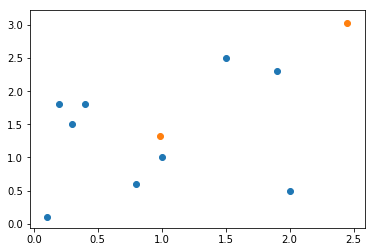

In [191]:
x = [a[0] for a in features]
y = [b[1] for b in features]
plt.scatter(x,y)
plt.scatter([0.988,2.451],[1.319,3.036])

In [195]:
lsi_vectors = []
line_count = 0
for vec in corpus_lsi[:10000]:
    print(vec)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[(0, 0.11080291981576146), (1, -0.007176128278111477), (2, -0.17411342086751663), (3, 0.25416841851935423), (4, -0.08794711404851965), (5, 0.08832337907032742), (6, -0.00488616506649692), (7, 0.0008482513809141071), (8, -0.03208762146287942), (9, -0.00875855052283941), (10, 0.04734280908436619), (11, 0.021500495642034646), (12, -0.04653720424185096), (13, -0.008111033079290566), (14, 0.023063605656119795), (15, -0.011144756168908771), (16, -0.005332441095334168), (17, 0.13918727075856765), (18, 0.0376107319940477), (19, 0.10088697424658528), (20, -2.171499776273977e-05), (21, -0.09048626001374768), (22, 0.018146717583896025), (23, 0.07620661194990441), (24, 0.08260968007013715), (25, 0.008292769132454861), (26, 0.06312956090898508), (27, -0.08588245776931926), (28, 0.057170234487509956), (29, -0.14522864484931503), (30, 0.03683458006196025), (31, -0.05983324044507783), (32, 0.0059440363745295955), (33, 0.05750916376339294), (34, 0.016053211309662647), (35, -0.00510428462616695), (36, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[(0, 0.11165625632707167), (1, 0.013434314552999331), (2, 0.016945756101800276), (3, -0.024675043204077735), (4, 0.2296965267598912), (5, 0.17698563327830685), (6, 0.040919231382808695), (7, 0.03045991204475368), (8, 0.03840274632129957), (9, 0.026451370063616128), (10, 0.013273692506469523), (11, 0.02547150016880429), (12, -0.015267338078854846), (13, -0.031700522746692925), (14, 0.0016917376939565509), (15, 0.06621830324706814), (16, -0.01609553102531816), (17, 0.02057482547700708), (18, 0.026431127217830114), (19, -0.0046205993900560295), (20, 0.028959471799955293), (21, 0.00015793081339135346), (22, 0.011704249141465438), (23, 0.008605895541231085), (24, 0.0182485280060653), (25, 0.00211850890673784), (26, 0.004308109457170446), (27, 0.009171087669823504), (28, -0.003575503716119825), (29, 0.005619296810731397), (30, 0.005019035301993581), (31, -0.0008151916268612087), (32, 0.006478657752696859), (33, -0.004485708771984672), (34, 0.0030487000046668477), (35, 0.001725191367734399),

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[(0, 0.00033867553718528213), (1, -1.1181578528112205e-05), (2, -0.0003205305337457736), (3, -0.0004675201553169683), (4, -0.00021735808067355615), (5, 0.0002413367295586386), (6, -0.0001024269343705492), (7, 0.00010438675406547052), (8, 6.351630456666432e-06), (9, 0.0001833249464103702), (10, -0.0001121323019172675), (11, 3.956703024336866e-05), (12, 0.00010974006460013041), (13, 8.800924588057206e-05), (14, -8.106552928737304e-05), (15, -9.592977512986535e-05), (16, 0.0001572978369979308), (17, -0.000286034072278445), (18, 0.00019189993913662262), (19, 4.770137881396549e-05), (20, 0.0002610216280746928), (21, 0.00039002881569062003), (22, 0.00023047917681639682), (23, -6.609977932565819e-06), (24, 0.00013242059799549073), (25, -0.00011009624255410608), (26, -0.0001719927175475278), (27, -7.6220782270535e-05), (28, 1.9904976916686057e-05), (29, 0.00010893818002164679), (30, 0.00012506844198166968), (31, -2.727249025807589e-05), (32, -2.820009928345308e-05), (33, -2.6026006061065232e-0

In [244]:
corpora.MmCorpus.serialize('corpus_lsi', corpus_lsi)

2019-06-05 10:36:52,830 : INFO : storing corpus in Matrix Market format to corpus_lsi
2019-06-05 10:36:52,849 : WARNING : this function is deprecated, use smart_open.open instead
2019-06-05 10:36:52,865 : INFO : saving sparse matrix to corpus_lsi
2019-06-05 10:36:53,004 : INFO : PROGRESS: saving document #0
2019-06-05 10:36:53,891 : INFO : PROGRESS: saving document #1000
2019-06-05 10:36:54,764 : INFO : PROGRESS: saving document #2000
2019-06-05 10:36:55,596 : INFO : PROGRESS: saving document #3000
2019-06-05 10:36:56,426 : INFO : PROGRESS: saving document #4000
2019-06-05 10:36:57,257 : INFO : PROGRESS: saving document #5000
2019-06-05 10:36:58,095 : INFO : PROGRESS: saving document #6000
2019-06-05 10:36:58,925 : INFO : PROGRESS: saving document #7000
2019-06-05 10:36:59,761 : INFO : PROGRESS: saving document #8000
2019-06-05 10:37:00,589 : INFO : PROGRESS: saving document #9000
2019-06-05 10:37:01,416 : INFO : PROGRESS: saving document #10000
2019-06-05 10:37:02,234 : INFO : PROGRES

2019-06-05 10:38:36,088 : INFO : PROGRESS: saving document #121000
2019-06-05 10:38:36,916 : INFO : PROGRESS: saving document #122000
2019-06-05 10:38:37,804 : INFO : PROGRESS: saving document #123000
2019-06-05 10:38:38,714 : INFO : PROGRESS: saving document #124000
2019-06-05 10:38:39,539 : INFO : PROGRESS: saving document #125000
2019-06-05 10:38:40,396 : INFO : PROGRESS: saving document #126000
2019-06-05 10:38:41,234 : INFO : PROGRESS: saving document #127000
2019-06-05 10:38:42,066 : INFO : PROGRESS: saving document #128000
2019-06-05 10:38:42,888 : INFO : PROGRESS: saving document #129000
2019-06-05 10:38:43,795 : INFO : PROGRESS: saving document #130000
2019-06-05 10:38:44,684 : INFO : PROGRESS: saving document #131000
2019-06-05 10:38:45,556 : INFO : PROGRESS: saving document #132000
2019-06-05 10:38:46,385 : INFO : PROGRESS: saving document #133000
2019-06-05 10:38:47,230 : INFO : PROGRESS: saving document #134000
2019-06-05 10:38:48,065 : INFO : PROGRESS: saving document #13

2019-06-05 10:40:19,876 : INFO : PROGRESS: saving document #244000
2019-06-05 10:40:20,696 : INFO : PROGRESS: saving document #245000
2019-06-05 10:40:21,511 : INFO : PROGRESS: saving document #246000
2019-06-05 10:40:22,336 : INFO : PROGRESS: saving document #247000
2019-06-05 10:40:23,148 : INFO : PROGRESS: saving document #248000
2019-06-05 10:40:23,960 : INFO : PROGRESS: saving document #249000
2019-06-05 10:40:24,785 : INFO : PROGRESS: saving document #250000
2019-06-05 10:40:25,611 : INFO : PROGRESS: saving document #251000
2019-06-05 10:40:26,428 : INFO : PROGRESS: saving document #252000
2019-06-05 10:40:27,254 : INFO : PROGRESS: saving document #253000
2019-06-05 10:40:28,060 : INFO : PROGRESS: saving document #254000
2019-06-05 10:40:28,865 : INFO : PROGRESS: saving document #255000
2019-06-05 10:40:29,693 : INFO : PROGRESS: saving document #256000
2019-06-05 10:40:30,482 : INFO : PROGRESS: saving document #257000
2019-06-05 10:40:31,305 : INFO : PROGRESS: saving document #25

2019-06-05 10:42:01,649 : INFO : PROGRESS: saving document #367000
2019-06-05 10:42:02,461 : INFO : PROGRESS: saving document #368000
2019-06-05 10:42:03,288 : INFO : PROGRESS: saving document #369000
2019-06-05 10:42:04,151 : INFO : PROGRESS: saving document #370000
2019-06-05 10:42:05,123 : INFO : PROGRESS: saving document #371000
2019-06-05 10:42:05,945 : INFO : PROGRESS: saving document #372000
2019-06-05 10:42:06,768 : INFO : PROGRESS: saving document #373000
2019-06-05 10:42:07,664 : INFO : PROGRESS: saving document #374000
2019-06-05 10:42:08,486 : INFO : PROGRESS: saving document #375000
2019-06-05 10:42:09,307 : INFO : PROGRESS: saving document #376000
2019-06-05 10:42:10,116 : INFO : PROGRESS: saving document #377000
2019-06-05 10:42:11,039 : INFO : PROGRESS: saving document #378000
2019-06-05 10:42:11,881 : INFO : PROGRESS: saving document #379000
2019-06-05 10:42:12,693 : INFO : PROGRESS: saving document #380000
2019-06-05 10:42:13,507 : INFO : PROGRESS: saving document #38

2019-06-05 10:43:44,022 : INFO : PROGRESS: saving document #490000
2019-06-05 10:43:44,838 : INFO : PROGRESS: saving document #491000
2019-06-05 10:43:45,665 : INFO : PROGRESS: saving document #492000
2019-06-05 10:43:46,507 : INFO : PROGRESS: saving document #493000
2019-06-05 10:43:47,357 : INFO : PROGRESS: saving document #494000
2019-06-05 10:43:48,202 : INFO : PROGRESS: saving document #495000
2019-06-05 10:43:49,046 : INFO : PROGRESS: saving document #496000
2019-06-05 10:43:49,863 : INFO : PROGRESS: saving document #497000
2019-06-05 10:43:50,675 : INFO : PROGRESS: saving document #498000
2019-06-05 10:43:51,493 : INFO : PROGRESS: saving document #499000
2019-06-05 10:43:52,354 : INFO : PROGRESS: saving document #500000
2019-06-05 10:43:53,226 : INFO : PROGRESS: saving document #501000
2019-06-05 10:43:54,079 : INFO : PROGRESS: saving document #502000
2019-06-05 10:43:54,894 : INFO : PROGRESS: saving document #503000
2019-06-05 10:43:55,701 : INFO : PROGRESS: saving document #50

2019-06-05 10:45:26,158 : INFO : PROGRESS: saving document #613000
2019-06-05 10:45:26,984 : INFO : PROGRESS: saving document #614000
2019-06-05 10:45:27,809 : INFO : PROGRESS: saving document #615000
2019-06-05 10:45:28,624 : INFO : PROGRESS: saving document #616000
2019-06-05 10:45:29,442 : INFO : PROGRESS: saving document #617000
2019-06-05 10:45:30,270 : INFO : PROGRESS: saving document #618000
2019-06-05 10:45:31,041 : INFO : PROGRESS: saving document #619000
2019-06-05 10:45:31,868 : INFO : PROGRESS: saving document #620000
2019-06-05 10:45:32,731 : INFO : PROGRESS: saving document #621000
2019-06-05 10:45:33,601 : INFO : PROGRESS: saving document #622000
2019-06-05 10:45:34,413 : INFO : PROGRESS: saving document #623000
2019-06-05 10:45:35,248 : INFO : PROGRESS: saving document #624000
2019-06-05 10:45:36,104 : INFO : PROGRESS: saving document #625000
2019-06-05 10:45:36,921 : INFO : PROGRESS: saving document #626000
2019-06-05 10:45:37,745 : INFO : PROGRESS: saving document #62

2019-06-05 10:47:10,089 : INFO : PROGRESS: saving document #736000
2019-06-05 10:47:10,888 : INFO : PROGRESS: saving document #737000
2019-06-05 10:47:11,699 : INFO : PROGRESS: saving document #738000
2019-06-05 10:47:12,513 : INFO : PROGRESS: saving document #739000
2019-06-05 10:47:13,315 : INFO : PROGRESS: saving document #740000
2019-06-05 10:47:14,129 : INFO : PROGRESS: saving document #741000
2019-06-05 10:47:14,932 : INFO : PROGRESS: saving document #742000
2019-06-05 10:47:15,754 : INFO : PROGRESS: saving document #743000
2019-06-05 10:47:16,567 : INFO : PROGRESS: saving document #744000
2019-06-05 10:47:17,380 : INFO : PROGRESS: saving document #745000
2019-06-05 10:47:18,186 : INFO : PROGRESS: saving document #746000
2019-06-05 10:47:18,991 : INFO : PROGRESS: saving document #747000
2019-06-05 10:47:19,834 : INFO : PROGRESS: saving document #748000
2019-06-05 10:47:20,661 : INFO : PROGRESS: saving document #749000
2019-06-05 10:47:21,471 : INFO : PROGRESS: saving document #75

2019-06-05 10:48:53,374 : INFO : PROGRESS: saving document #859000
2019-06-05 10:48:54,203 : INFO : PROGRESS: saving document #860000
2019-06-05 10:48:55,020 : INFO : PROGRESS: saving document #861000
2019-06-05 10:48:55,839 : INFO : PROGRESS: saving document #862000
2019-06-05 10:48:56,668 : INFO : PROGRESS: saving document #863000
2019-06-05 10:48:57,508 : INFO : PROGRESS: saving document #864000
2019-06-05 10:48:58,408 : INFO : PROGRESS: saving document #865000
2019-06-05 10:48:59,306 : INFO : PROGRESS: saving document #866000
2019-06-05 10:49:00,171 : INFO : PROGRESS: saving document #867000
2019-06-05 10:49:00,989 : INFO : PROGRESS: saving document #868000
2019-06-05 10:49:01,815 : INFO : PROGRESS: saving document #869000
2019-06-05 10:49:02,651 : INFO : PROGRESS: saving document #870000
2019-06-05 10:49:03,545 : INFO : PROGRESS: saving document #871000
2019-06-05 10:49:04,403 : INFO : PROGRESS: saving document #872000
2019-06-05 10:49:05,264 : INFO : PROGRESS: saving document #87

2019-06-05 10:50:50,046 : INFO : PROGRESS: saving document #982000
2019-06-05 10:50:50,859 : INFO : PROGRESS: saving document #983000
2019-06-05 10:50:51,679 : INFO : PROGRESS: saving document #984000
2019-06-05 10:50:52,497 : INFO : PROGRESS: saving document #985000
2019-06-05 10:50:53,326 : INFO : PROGRESS: saving document #986000
2019-06-05 10:50:54,161 : INFO : PROGRESS: saving document #987000
2019-06-05 10:50:54,998 : INFO : PROGRESS: saving document #988000
2019-06-05 10:50:55,812 : INFO : PROGRESS: saving document #989000
2019-06-05 10:50:56,639 : INFO : PROGRESS: saving document #990000
2019-06-05 10:50:57,465 : INFO : PROGRESS: saving document #991000
2019-06-05 10:50:58,283 : INFO : PROGRESS: saving document #992000
2019-06-05 10:50:59,093 : INFO : PROGRESS: saving document #993000
2019-06-05 10:50:59,920 : INFO : PROGRESS: saving document #994000
2019-06-05 10:51:00,733 : INFO : PROGRESS: saving document #995000
2019-06-05 10:51:01,565 : INFO : PROGRESS: saving document #99

2019-06-05 10:52:29,704 : INFO : PROGRESS: saving document #1103000
2019-06-05 10:52:30,539 : INFO : PROGRESS: saving document #1104000
2019-06-05 10:52:31,378 : INFO : PROGRESS: saving document #1105000
2019-06-05 10:52:32,236 : INFO : PROGRESS: saving document #1106000
2019-06-05 10:52:33,075 : INFO : PROGRESS: saving document #1107000
2019-06-05 10:52:33,913 : INFO : PROGRESS: saving document #1108000
2019-06-05 10:52:34,820 : INFO : PROGRESS: saving document #1109000
2019-06-05 10:52:35,616 : INFO : PROGRESS: saving document #1110000
2019-06-05 10:52:36,442 : INFO : PROGRESS: saving document #1111000
2019-06-05 10:52:37,269 : INFO : PROGRESS: saving document #1112000
2019-06-05 10:52:38,117 : INFO : PROGRESS: saving document #1113000
2019-06-05 10:52:38,983 : INFO : PROGRESS: saving document #1114000
2019-06-05 10:52:39,818 : INFO : PROGRESS: saving document #1115000
2019-06-05 10:52:40,662 : INFO : PROGRESS: saving document #1116000
2019-06-05 10:52:41,487 : INFO : PROGRESS: savin

2019-06-05 10:54:11,660 : INFO : PROGRESS: saving document #1224000
2019-06-05 10:54:12,486 : INFO : PROGRESS: saving document #1225000
2019-06-05 10:54:13,314 : INFO : PROGRESS: saving document #1226000
2019-06-05 10:54:14,136 : INFO : PROGRESS: saving document #1227000
2019-06-05 10:54:14,944 : INFO : PROGRESS: saving document #1228000
2019-06-05 10:54:15,763 : INFO : PROGRESS: saving document #1229000
2019-06-05 10:54:16,583 : INFO : PROGRESS: saving document #1230000
2019-06-05 10:54:17,397 : INFO : PROGRESS: saving document #1231000
2019-06-05 10:54:18,209 : INFO : PROGRESS: saving document #1232000
2019-06-05 10:54:19,027 : INFO : PROGRESS: saving document #1233000
2019-06-05 10:54:19,857 : INFO : PROGRESS: saving document #1234000
2019-06-05 10:54:20,684 : INFO : PROGRESS: saving document #1235000
2019-06-05 10:54:21,509 : INFO : PROGRESS: saving document #1236000
2019-06-05 10:54:22,326 : INFO : PROGRESS: saving document #1237000
2019-06-05 10:54:23,099 : INFO : PROGRESS: savin

In [193]:
print(len(corpus_lsi))

1258357


In [196]:
def k_means(vecs, k, iter = 300, distortion = 0.00005):
    if type(k) != int:
        return None

In [199]:
corpus_lsi.save('corpus_lsi')

/anaconda3/lib/python3.7/site-packages/gensim/interfaces.py:101: UserWarning: corpus.save() stores only the (tiny) iteration object; to serialize the actual corpus content, use e.g. MmCorpus.serialize(corpus)
  "corpus.save() stores only the (tiny) iteration object; "
2019-06-04 17:14:32,544 : INFO : saving TransformedCorpus object under corpus_lsi, separately None
2019-06-04 17:14:32,546 : INFO : storing np array 'u' to corpus_lsi.obj.projection.u.npy
2019-06-04 17:14:33,465 : WARNING : this function is deprecated, use smart_open.open instead
2019-06-04 17:14:44,543 : INFO : saved corpus_lsi


In [205]:
print(type(corpus_lsi))
corpus_lsi.load('corpus_lsi')

2019-06-04 17:22:19,826 : INFO : loading TransformedCorpus object from corpus_lsi
2019-06-04 17:22:19,827 : WARNING : this function is deprecated, use smart_open.open instead


<class 'gensim.interfaces.TransformedCorpus'>


2019-06-04 17:22:33,269 : INFO : loading obj recursively from corpus_lsi.obj.* with mmap=None
2019-06-04 17:22:33,276 : INFO : loading id2word recursively from corpus_lsi.obj.id2word.* with mmap=None
2019-06-04 17:22:33,277 : INFO : loading projection recursively from corpus_lsi.obj.projection.* with mmap=None
2019-06-04 17:22:33,278 : INFO : loading u from corpus_lsi.obj.projection.u.npy with mmap=None
2019-06-04 17:22:33,864 : INFO : loading corpus recursively from corpus_lsi.corpus.* with mmap=None
2019-06-04 17:22:33,867 : INFO : loading obj recursively from corpus_lsi.corpus.obj.* with mmap=None
2019-06-04 17:22:33,867 : INFO : loaded corpus_lsi


TypeError: 'str' object is not callable

In [215]:
f = open('OutPutData/lsi_vecs.txt', "w+")
for vec in corpus_lsi[:10]:
    vec = [str(tup[1]) for tup in vec]
    temp = ' '.join(vec)
    f.write(temp + ',')

In [ ]:
with open('OutPutData/lsi_vecs.txt') as file:
    reader = csv.reader(file, delimiter=' ')